In [1]:
import pandas as pd
import numpy as np
import os
import env

import reg_wrangle as rw


from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score


from sklearn.feature_selection import f_regression 
from math import sqrt
import matplotlib.pyplot as plt

import seaborn as sns

## 1. Load zillow data set

In [2]:
train, validate, test, train_scaled, validate_scaled, test_scaled = rw.wrangle_zillow()

In [3]:
train.head()

,bed_rooms,bath_rooms,finished_sqft,tax_val_dollar_count,year_built,tax_amt,fips
666455,3,3.0,1620,241434,1989,2251.46,6059
1783637,3,1.0,1557,280212,1948,4274.29,6037
1250454,3,2.0,1512,335993,1965,4238.40,6037
800277,2,4.0,1932,63740,1939,973.80,6037
1382185,3,2.0,1411,282027,1965,3548.28,6037


In [4]:
# must make it a dataframe can not take in a series 
# read it as series if it is only one column

x_train = train[['finished_sqft']]
y_train = train.tax_val_dollar_count

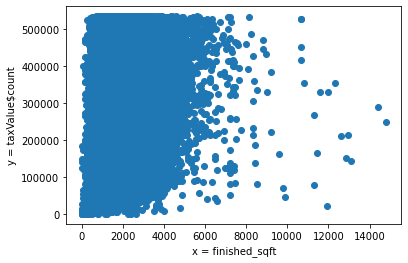

In [5]:
# look at scatter of x vs y
plt.scatter(x_train, y_train)

plt.xlabel('x = finished_sqft')
plt.ylabel('y = taxValue$count')
plt.show()

## 2. Fit the model

In [6]:
from sklearn.linear_model import LinearRegression
# generate parameters, i.e. create model
# ols_model = LinearRegression().fit(df[['x']], df.y)

# compute predictions and add to original dataframe
# df['yhat'] = ols_model.predict(df[['x']])

# assuming X and y are already defined
model = LinearRegression().fit(x_train, y_train)
train['yhat'] = model.predict(x_train)

In [31]:
predictions = train['yhat']

In [7]:
train.head()

,bed_rooms,bath_rooms,finished_sqft,tax_val_dollar_count,year_built,tax_amt,fips,yhat
666455,3,3.0,1620,241434,1989,2251.46,6059,264248.479798
1783637,3,1.0,1557,280212,1948,4274.29,6037,260075.615063
1250454,3,2.0,1512,335993,1965,4238.40,6037,257094.997395
800277,2,4.0,1932,63740,1939,973.80,6037,284914.095630
1382185,3,2.0,1411,282027,1965,3548.28,6037,250405.166629


In [8]:
train['yhat_baseline'] = y_train.mean()


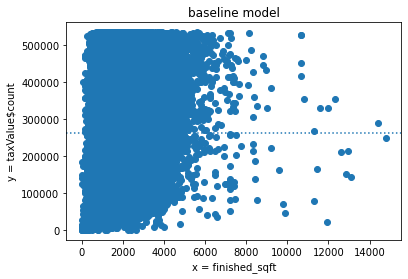

In [9]:
# plot data with baseline:
plt.scatter(x_train, y_train)
plt.axhline(y_train.mean(), ls=':')

plt.xlabel('x = finished_sqft')
plt.ylabel('y = taxValue$count')
plt.title('baseline model')
plt.show()

In [10]:
train.head()

,bed_rooms,bath_rooms,finished_sqft,tax_val_dollar_count,year_built,tax_amt,fips,yhat,yhat_baseline
666455,3,3.0,1620,241434,1989,2251.46,6059,264248.479798,261827.410386
1783637,3,1.0,1557,280212,1948,4274.29,6037,260075.615063,261827.410386
1250454,3,2.0,1512,335993,1965,4238.40,6037,257094.997395,261827.410386
800277,2,4.0,1932,63740,1939,973.80,6037,284914.095630,261827.410386
1382185,3,2.0,1411,282027,1965,3548.28,6037,250405.166629,261827.410386


In [11]:
####  Lesson
# residual = actual - predicted  
# baseline = actual - baseline
#df['baseline_residual'] = df.y - df.baseline
# residual is taking actual minus what we predicted
#df['residual'] = df.y - df.yhat

train['residual'] = y_train - train['yhat']
train['residual_baseline'] = y_train - train['yhat_baseline']


## 3. Plot residuals

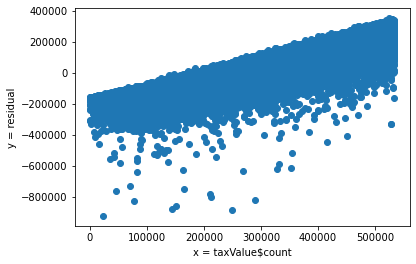

In [32]:
plt.scatter(y_train, train['residual'])
plt.xlabel('x = taxValue$count')
plt.ylabel('y = residual')
plt.show()

In [13]:
train.head()

,bed_rooms,bath_rooms,finished_sqft,tax_val_dollar_count,year_built,tax_amt,fips,yhat,yhat_baseline,residual,residual_baseline
666455,3,3.0,1620,241434,1989,2251.46,6059,264248.479798,261827.410386,-22814.479798,-20393.410386
1783637,3,1.0,1557,280212,1948,4274.29,6037,260075.615063,261827.410386,20136.384937,18384.589614
1250454,3,2.0,1512,335993,1965,4238.40,6037,257094.997395,261827.410386,78898.002605,74165.589614
800277,2,4.0,1932,63740,1939,973.80,6037,284914.095630,261827.410386,-221174.095630,-198087.410386
1382185,3,2.0,1411,282027,1965,3548.28,6037,250405.166629,261827.410386,31621.833371,20199.589614


In [15]:
# square each residual value
train['residual^2'] = train.residual ** 2

train['residual_baseline^2'] = train.residual_baseline ** 2

train.head(3)


,bed_rooms,bath_rooms,finished_sqft,tax_val_dollar_count,year_built,tax_amt,fips,yhat,yhat_baseline,residual,residual_baseline,residual^2,residual_baseline^2
666455,3,3.0,1620,241434,1989,2251.46,6059,264248.479798,261827.410386,-22814.479798,-20393.410386,5.205005e+08,4.158912e+08
1783637,3,1.0,1557,280212,1948,4274.29,6037,260075.615063,261827.410386,20136.384937,18384.589614,4.054740e+08,3.379931e+08
1250454,3,2.0,1512,335993,1965,4238.40,6037,257094.997395,261827.410386,78898.002605,74165.589614,6.224895e+09,5.500535e+09


## 4. & 5. calculate for model and baseline

In [16]:
# SSE
SSE = sum(train['residual^2'])
SSE_baseline = sum(train['residual_baseline^2'])

print("SSE = ", SSE)
print("SSE - baseline = ", SSE_baseline)


SSE =  1.5356059770559164e+16
SSE - baseline =  1.6660989878545426e+16


In [17]:
MSE = SSE/len(train)
MSE_baseline = SSE_baseline/len(train)

print("MSE = ", MSE)
print("MSE baseline = ", MSE_baseline)


MSE =  17087426136.40418
MSE baseline =  18539484617.977364


In [18]:
from sklearn.metrics import mean_squared_error

In [19]:
MSE2_baseline = mean_squared_error(y_train, train.yhat_baseline)
MSE2 = mean_squared_error(y_train, train.yhat)

In [20]:
print(MSE2)
print(MSE2_baseline)

17087426136.40312
18539484617.97503


In [21]:
from math import sqrt
RMSE = sqrt(MSE)
RMSE_baseline = sqrt(MSE_baseline)

print("RMSE = ", RMSE)
print("RMSE baseline = ", RMSE_baseline)


RMSE =  130718.88209590908
RMSE baseline =  136159.77606465635


In [22]:
df_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
df_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])

df_eval['model_error'] = np.array([SSE, MSE, RMSE])
df_baseline_eval['model_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])

print(df_eval)
print(df_baseline_eval)


  metric   model_error
0    SSE  1.535606e+16
1    MSE  1.708743e+10
2   RMSE  1.307189e+05
          metric   model_error
0   SSE_baseline  1.666099e+16
1   MSE_baseline  1.853948e+10
2  RMSE_baseline  1.361598e+05


In [23]:
df_eval['error_delta'] = df_eval.model_error - df_baseline_eval.model_error
df_eval


,metric,model_error,error_delta
0,SSE,1.535606e+16,-1.304930e+15
1,MSE,1.708743e+10,-1.452058e+09
2,RMSE,1.307189e+05,-5.440894e+03


In [24]:
TSS = SSE_baseline

## 7. Amount of Variance

In [25]:
ESS = TSS - SSE
ESS

1304930107986262.0

In [26]:
R2 = ESS/TSS
R2

0.07832248368787724

## 6. Function

In [27]:
def good_model(SSE, SSE_baseline):
    if SSE < SSE_baseline:
        print('better than baseline')
    else:
        print('not better than baseline')

## 8. Is model better?

In [28]:
good_model(SSE, SSE_baseline)

better than baseline


## 9. evaluate.py file